# Outlier analysis 

When plotting true vs predicted ED attendances (see [Combined Population Health and Service Capacity Model](./stacked_model.ipynb) and below) there are two clusters of points that appear to be outliers: Liverpool and Hull.

To understand why these points are outliers in the following we:

- fit the model without these points and assess change in performance
- investigate the relationship between population health variables and mean monthly ED attendances for these points

In [1]:
#turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings('ignore')

## Import libraries 

In [2]:
import os
import pandas as pd
import numpy as np
import pickle as pkl

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor


from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import r2_score as r2


import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

## Import data 

In [3]:
dta = pd.read_csv('../data/master_scaled_new.csv', index_col=0)

In [4]:
dta.columns = ['_'.join([c.split('/')[0],c.split('/')[-1]])
               if '/' in c else c for c in dta.columns]

In [5]:
dta.head()

,ccg,month,111_111_offered,111_111_answered,amb_sys_made,amb_sys_answered,gp_appt_available,ae_attendances_attendances,population,People,Places,Lives,year
0,00Q,Jan,406.655830,308.945095,310.561801,234.716187,4568.019766,1179.855246,14.8942,97.2,99.7,94.4,2018
1,00Q,Feb,349.933603,256.872981,261.756435,205.298797,3910.918344,1075.452189,14.8942,97.2,99.7,94.4,2018
2,00Q,Mar,413.247659,300.690725,303.676215,234.716187,4051.778545,1210.874032,14.8942,97.2,99.7,94.4,2018
3,00Q,Apr,349.608595,278.140171,264.973181,203.677924,3974.433001,1186.166427,14.8942,97.2,99.7,94.4,2018
4,00Q,May,361.100544,284.419492,294.361403,227.926437,4232.385761,1299.297713,14.8942,97.2,99.7,94.4,2018


In [6]:
dta.shape

(1618, 13)

## Function to group data 

In [7]:
def group_data(data, features):

    features = ['population',
                'People', 'Places',
                'Lives']


    #ensure no identical points in train and test

    grouped = pd.DataFrame()
    
    for pop, group in data.groupby('population'):

        #if len(group.lives.unique())>1:

            #print('multiple CCG with same population')

        ccg_year = pd.Series(dtype='float64')

        for f in features:

            ccg_year[f] = group[f].unique()[0]

        ccg_year['ae_attendances_attendances']\
        = group.ae_attendances_attendances.mean()
        

        grouped = grouped.append(ccg_year, ignore_index=True)
        
    return grouped

## Functions to fit model 

In [8]:
def fit_ph(dta, features, model):
    
    if 'ae_predicted' in dta.columns:
        
        dta = dta.drop(['ae_predicted'], axis=1)
    
    grouped = group_data(dta, features)
    
    y = grouped['ae_attendances_attendances']

    X = grouped[features]

    # dont set random state so that function can be used in overall cv
    cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
    
    results = pd.DataFrame()
    
    for train_index, test_index in cv.split(X, y):
        
        model.fit(X.iloc[train_index], y.iloc[train_index])
        
        test = X.iloc[test_index].copy()
        
        test['ae_predicted'] = model.predict(X.iloc[test_index])
    
        results = results.append(test, ignore_index=True)
        
    dta = dta.merge(results[['population','ae_predicted']],
                    left_on='population', right_on='population')
        
    return dta

In [9]:
def fit_capacity(dta, features, model):
    
    y = dta['ae_attendances_attendances']
    X = dta[features]

    model.fit(X,y)
    
    return model

In [10]:
def fit_combined(train, rf1, m1_features, train_size=7/8):
    
    final = LinearRegression()

    #split training data into two sets
    train_0, train_1 = train_test_split(train, 
                                        train_size=train_size, 
                                        random_state=29)

    #train capactiy model
    
    rf1 = fit_capacity(train_0, m1_features, rf1)
    

    #predict monthly attendances

    y_pred_1 = rf1.predict(train_1[m1_features])

    
    #use pre-predicted average attendances
    
    y_pred_2 = train_1['ae_predicted']
        
    #final
        
    X_f = np.vstack([y_pred_1, y_pred_2]).T
    y_f = train_1['ae_attendances_attendances']

    final.fit(X_f,y_f)
    
    return rf1,final        

In [11]:
def cv_combined(dta, rf1, rf2):
    
    # splitter for cross validation 
    
    cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
    
    scores_final, scores_rf1, scores_rf2, coefs = [],[],[],[]
    
    k=1
    
    capacity_features = ['gp_appt_available',
            '111_111_offered', 'amb_sys_answered']

    pophealth_features = ['population',
                            'People', 'Places', 'Lives']
    
    dta_pred = pd.DataFrame()
    
    #fit population health independently to avoid data leakage
    
    dta = fit_ph(dta, pophealth_features, rf2)
    
    print(dta.shape)
    
    for train_index, test_index in cv.split(dta):
        
        #print(f'\n Split {k} \n')
        
        train = dta.iloc[train_index]
        test = dta.iloc[test_index]

        #final models
        rf1, final = fit_combined(train, rf1, capacity_features)
        
        coefs.append(final.coef_)
        
        #predict on test data
        
        y_pred_cu = rf1.predict(test[capacity_features])

        scores_rf1.append(rf1.score(test[capacity_features],
                                    test['ae_attendances_attendances']))

        y_pred_ph = test['ae_predicted']

        scores_rf2.append(r2(test['ae_attendances_attendances'],
                             test['ae_predicted']))
        
        preds = final.predict(np.vstack([y_pred_cu, y_pred_ph]).T)

        scores_final.append(final.score(np.vstack([y_pred_cu, y_pred_ph]).T,
                                        test['ae_attendances_attendances']))
        
        test_pred = test.copy()
        test_pred['predicted'] = preds
        test_pred['true'] = test['ae_attendances_attendances'].values
        
        test_pred['iter'] = [k for i in test_pred.index]
        
        dta_pred = dta_pred.append(test_pred, ignore_index=False)
        
        
        k+=1
        
    return scores_final, scores_rf1, scores_rf2, dta_pred, coefs

## Fit model 

In [12]:
#capacity model
rf1 = RandomForestRegressor(max_depth=5, n_estimators=6, random_state=0)

#population health model
rf2 = RandomForestRegressor(max_depth=5, n_estimators=4, random_state=0)

scores_final, scores_rf1, scores_rf2, \
dta_pred, coefs = cv_combined(dta, rf1, rf2)

(1618, 14)


In [13]:
results=pd.DataFrame()

results['final'] = scores_final

In [14]:
results.describe()

,final
count,25.000000
mean,0.746522
std,0.029963
min,0.696823
25%,0.714364
50%,0.751038
75%,0.773550
max,0.796107


### Coefficient importances 

#### Mean 

In [15]:
np.mean(coefs, axis=0)

array([0.37039636, 0.75446076])

#### Std 

In [16]:
np.std(coefs, axis=0)

array([0.08350285, 0.08470623])

### Plot 

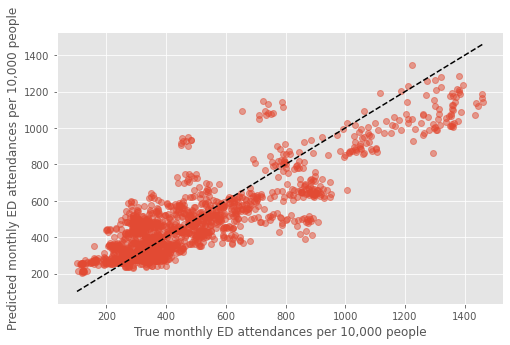

In [17]:
fig,ax = plt.subplots(figsize=(8,5))

mean_pred, true = [],[]

for i in dta_pred.index.unique():
    
    mean_pred.append(dta_pred.loc[i]['predicted'].mean())
    true.append(dta_pred.loc[i]['true'].mean())

plt.plot(true, mean_pred, 'o', alpha=0.5)

xx = np.arange(min(dta_pred['true']),max(dta_pred['true']))
plt.plot(xx,xx,'k--')

plt.xlabel('True monthly ED attendances per 10,000 people')
plt.ylabel('Predicted monthly ED attendances per 10,000 people')
plt.savefig('true_predicted_combined.png', dpi=300)
plt.show()

## Remove Outliers (Hull and Liverpool) 

In [18]:
dta.loc[dta.ccg=='03F']#.shape

,ccg,month,111_111_offered,111_111_answered,amb_sys_made,amb_sys_answered,gp_appt_available,ae_attendances_attendances,population,People,Places,Lives,year
168,03F,Jan,311.481539,305.050947,203.403017,139.491600,4964.760498,711.143509,26.0645,89.4,92.5,89.1,2018
169,03F,Feb,270.177030,262.694921,192.519618,138.454451,4406.146291,655.226074,26.0645,89.4,92.5,89.1,2018
170,03F,Mar,324.018052,300.103371,219.041964,157.986876,4704.252911,724.854879,26.0645,89.4,92.5,89.1,2018
171,03F,Apr,323.018901,288.461277,198.272296,140.815550,4323.773715,734.428053,26.0645,89.4,92.5,89.1,2018
172,03F,May,327.195644,293.838257,209.814335,154.673667,4469.757716,792.073510,26.0645,89.4,92.5,89.1,2018
173,03F,Jun,282.556443,255.916616,203.076199,151.105340,4083.216636,750.714573,26.0645,89.4,92.5,89.1,2018
174,03F,Jul,302.757300,275.694352,221.946649,160.854878,4051.948052,787.776478,26.0645,89.4,92.5,89.1,2018
175,03F,Aug,288.159646,271.316522,209.142356,148.732568,3657.810432,741.391548,26.0645,89.4,92.5,89.1,2018
176,03F,Sep,287.261039,266.293539,207.219794,149.031041,3888.660822,711.504153,26.0645,89.4,92.5,89.1,2018
177,03F,Oct,308.517602,274.766420,216.078918,152.209187,5052.197433,758.004182,26.0645,89.4,92.5,89.1,2018


In [19]:
dta.loc[dta.ccg=='99A']

,ccg,month,111_111_offered,111_111_answered,amb_sys_made,amb_sys_answered,gp_appt_available,ae_attendances_attendances,population,People,Places,Lives,year
665,99A,Jan,406.655830,308.945095,310.561801,234.716187,4713.508510,897.064351,49.4814,87.8,98.6,91.4,2018
666,99A,Feb,349.933603,256.872981,261.756435,205.298797,4152.772557,776.049182,49.4814,87.8,98.6,91.4,2018
667,99A,Mar,413.247659,300.690725,303.676215,234.716187,4405.453362,897.751478,49.4814,87.8,98.6,91.4,2018
668,99A,Apr,349.608595,278.140171,264.973181,203.677924,4046.510406,848.116666,49.4814,87.8,98.6,91.4,2018
669,99A,May,361.100544,284.419492,294.361403,227.926437,4299.837919,921.396727,49.4814,87.8,98.6,91.4,2018
670,99A,Jun,328.551827,254.368753,281.106911,220.213747,4020.460213,863.698279,49.4814,87.8,98.6,91.4,2018
671,99A,Jul,339.766686,248.935286,297.869823,235.572458,4166.899077,883.604748,49.4814,87.8,98.6,91.4,2018
672,99A,Aug,300.161546,239.420469,274.165073,213.851091,3994.591907,803.837402,49.4814,87.8,98.6,91.4,2018
673,99A,Sep,302.357433,244.118501,269.156617,209.471816,3998.512572,822.511085,49.4814,87.8,98.6,91.4,2018
674,99A,Oct,326.893453,255.939625,299.024018,230.861925,5037.165480,880.753980,49.4814,87.8,98.6,91.4,2018


In [20]:
hull = dta.loc[(dta.ccg=='03F') & (dta.year==2018)]
liv = dta.loc[(dta.ccg=='99A') & (dta.year==2019)]

In [21]:
dta2 = dta.drop(hull.index)
dta2 = dta2.drop(liv.index)

scores_final, scores_rf1, scores_rf2, \
dta_pred, coefs = cv_combined(dta2, rf1, rf2)

(1594, 14)


### Results

In [22]:
results=pd.DataFrame()

results['final'] = scores_final

In [23]:
results.describe()

,final
count,25.000000
mean,0.749989
std,0.036317
min,0.650637
25%,0.737499
50%,0.752755
75%,0.775938
max,0.798717


### Plot 

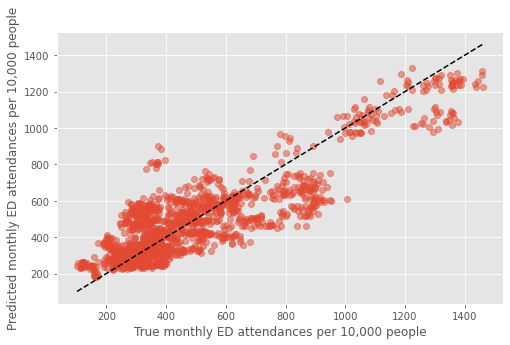

In [24]:
fig,ax = plt.subplots(figsize=(8,5))

mean_pred, true = [],[]

for i in dta_pred.index.unique():
    
    mean_pred.append(dta_pred.loc[i]['predicted'].mean())
    true.append(dta_pred.loc[i]['true'].mean())

plt.plot(true, mean_pred, 'o', alpha=0.5)

xx = np.arange(min(dta_pred['true']),max(dta_pred['true']))
plt.plot(xx,xx,'k--')

plt.xlabel('True monthly ED attendances per 10,000 people')
plt.ylabel('Predicted monthly ED attendances per 10,000 people')
plt.savefig('true_predicted_combined.png', dpi=300)
plt.show()

## Plot coloured by each grouped feature 

In [25]:
features = ['population',
            'People', 'Places', 'Lives']

grouped = group_data(dta, features)

In [26]:
grouped

,population,People,Places,Lives,ae_attendances_attendances
0,11.6159,94.800000,103.700000,95.400000,1024.414811
1,11.6571,97.400000,104.200000,96.300000,1059.954877
2,13.9240,84.800000,98.500000,88.500000,1362.970411
3,13.9305,85.800000,97.600000,88.000000,1275.055932
4,14.8942,97.200000,99.700000,94.400000,1111.556848
...,...,...,...,...,...
140,186.1075,101.100000,97.825000,102.406250,371.421898
141,200.8447,103.657143,96.357143,94.585714,442.040841
142,202.9265,103.842857,96.414286,94.585714,429.112528
143,209.5479,105.755556,95.666667,97.155556,554.092008


In [27]:
scores_final, scores_rf1, scores_rf2, \
dta_pred, coefs = cv_combined(dta, rf1, rf2)

(1618, 14)


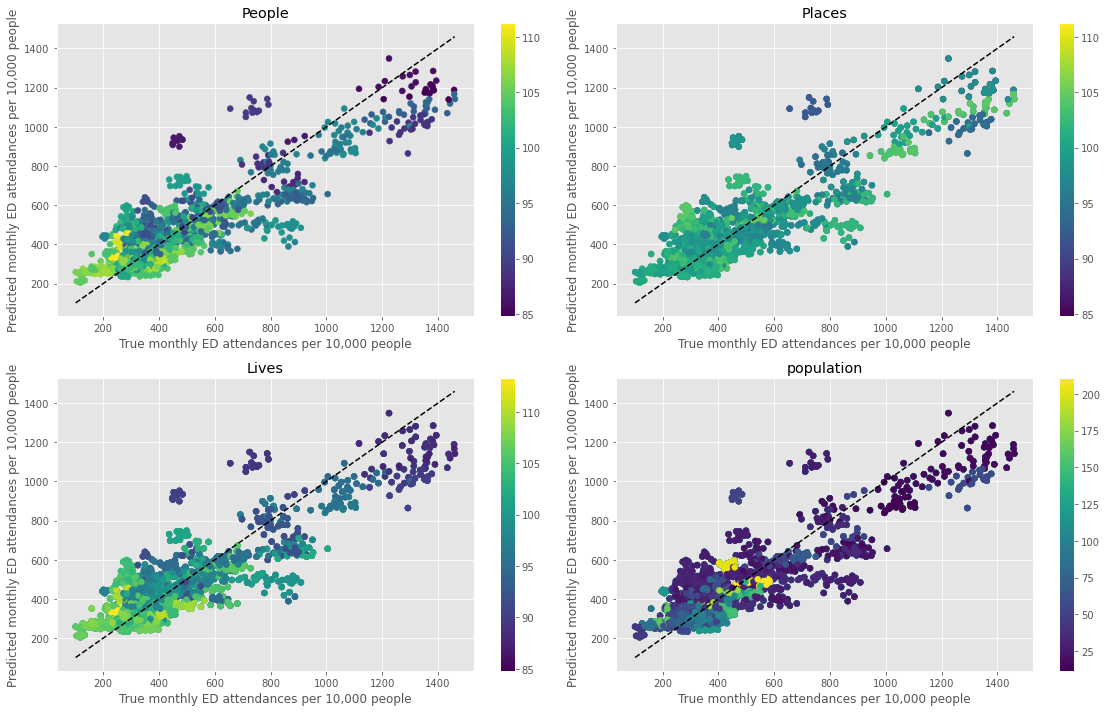

In [28]:
fig,ax_list = plt.subplots(2,2, figsize=(16,10))

mean_pred, true, col = [],[],[]

feats = ['People','Places','Lives','population']
# convert range into 

for i,f in enumerate(feats):
    
    ax = ax_list.flatten()[i]
    
    for i in dta_pred.index.unique():

        mean_pred.append(dta_pred.loc[i]['predicted'].mean())
        true.append(dta_pred.loc[i]['true'].mean())
        col.append(dta_pred.loc[i][f].mean())


    p = ax.scatter(true, mean_pred,  c = col, cmap='viridis')

    xx = np.arange(min(dta_pred['true']),max(dta_pred['true']))
    ax.plot(xx,xx,'k--')

    ax.set_xlabel('True monthly ED attendances per 10,000 people')
    ax.set_ylabel('Predicted monthly ED attendances per 10,000 people')
    ax.set_title(f'{f}')
    
    fig.colorbar(p, pad=0.05, ax=ax)
    
plt.tight_layout()
    
plt.savefig('true_predicted_grouped.png', dpi=300)
plt.show()

## Plot predicted mean monthly attendances 

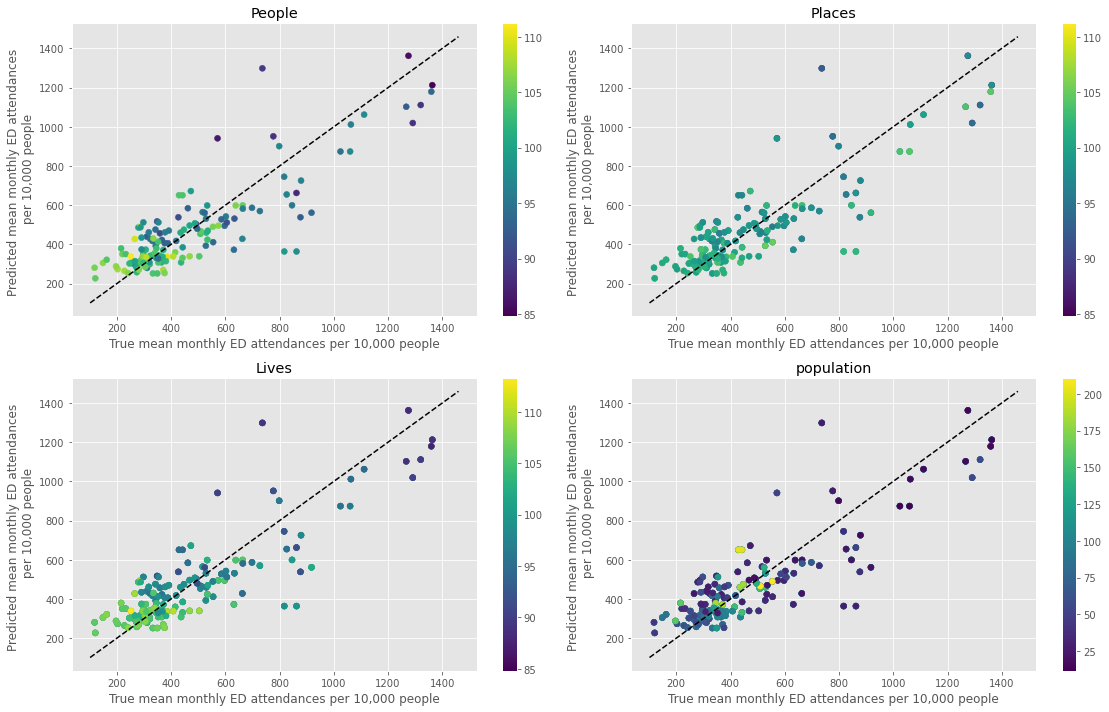

In [29]:
fig,ax_list = plt.subplots(2,2, figsize=(16,10))

mean_pred, true, col = [],[],[]

feats = ['People','Places','Lives','population']
# convert range into 

for i,f in enumerate(feats):
    
    ax = ax_list.flatten()[i]
    
    for c in dta_pred.ccg.unique():
        
        for y in dta_pred.year.unique():

            mean_pred.append(dta_pred.loc[(dta_pred.ccg==c) & (dta_pred.year==y)]['ae_predicted'].mean())
            true.append(dta_pred.loc[(dta_pred.ccg==c) & (dta_pred.year==y)]['true'].mean())
            col.append(dta_pred.loc[(dta_pred.ccg==c) & (dta_pred.year==y)][f].mean())


    p = ax.scatter(true, mean_pred,  c = col, cmap='viridis')

    xx = np.arange(min(dta_pred['true']),max(dta_pred['true']))
    ax.plot(xx,xx,'k--')

    ax.set_xlabel('True mean monthly ED attendances per 10,000 people')
    ax.set_ylabel('Predicted mean monthly ED attendances \n per 10,000 people')
    ax.set_title(f'{f}')
    
    fig.colorbar(p, pad=0.05, ax=ax)
    
plt.tight_layout()
    
plt.savefig('true_predicted_mean.png', dpi=300)
plt.show()

## Summary 

From the above figure, the outliers points have low values of 'People' and 'Lives'. When fitting the population health model, as variables only change annually there are fewer datapoints (145 total).

Looking at the ‘Lives’ panel in the final figure, if the model is trained on a subsection of the data that contains data points with low values of this variable (darker points) but high mean monthly ED attendances (cluster in top right), it will predict that an unseen datapoint with a low value of Lives has a high number of ED attendances (dark point centre top – that’s Hull).

As the MGSR assigns a higher weight to the population health model, if the prediction of the population health model isn’t as good for a given ccg, that ccg will be an outlier overall. Model perfomance would improve with an increased amount of data in the future.